# Bayesian Parameter Estimation

Let's consider the same sample as last week but now let's use Bayesian statistics to learn about the intrinsic parameters of the distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

In [2]:
sample = np.array([2.52736237, 0.21894346, 3.86047587, 4.41179758, 4.8242353,
                   1.15082906, 9.00623006, 4.30556281, 2.59794533, 7.00975095])

## General steps for a Bayesian Analysis

1. Define your priors
1. Specify how to calculate the likelihood
1. Now you can build your posterior and interrogate it
    - If your posterior can be treated analytically, you can just plot it, ask about the its maximum, confidence intervals, etc.
    - If it's not easily treated analytically, then you can draw a random sample from it using, for example, MCMC methods and ask the same questions based on the random sample.

### 1. Define the prior

We know nothing about this sample (this is not always the case), so we need to give as little info as possible. The goal is to define a function that when evaluated we get the probability density associated to the parameter values.

We will use `emcee` in this example, so we actually need to define a function that returns log of the prior.

In [3]:
def log_prior(params):
    mu, sigma = params
    # Complete this part
    if -100 < mu < 100 and 0 < sigma < 10:
        return 0.
    return -np.inf

### 2. Specify how to calculate the likelihood

This is the crucial part, we need to be able to estimate the probability density associated to obtaining a given datum, given a set of parameters.

Again, because we are using `emcee`, we need to create a function that returns the log of the likelihood.

In [4]:
def log_likelihood(params, data):
    mu, sigma = params
    # Complete this function.
    # Assume the points come from a gaussian and that they are independent.
    return -0.5 * np.sum((data - mu)**2 / sigma**2) - len(data) * np.log(sigma)

### 3. Build and Interrogate the Posterior

In [5]:
def log_posterior(params, data):
    # This one should not change
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(params, data) + log_prior(params)

In [6]:
log_posterior([0, 100], sample)

-inf

In [7]:
mu_to_plot = np.linspace(-5, 10, 100)
sigma_to_plot = np.linspace(0.01, 10, 50)
log_posterior_to_plot = np.zeros((100, 50))

for i in range(100):
    for j in range(50):
        mu_i = mu_to_plot[i]
        sigma_j = sigma_to_plot[j]
        log_posterior_to_plot[i, j] = log_posterior([mu_i, sigma_j], sample)

Text(0, 0.5, '$\\mu$')

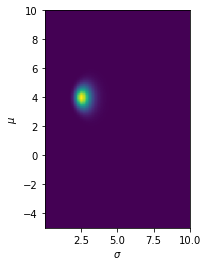

In [8]:
plt.imshow(10**log_posterior_to_plot, extent=[0.01, 10, -5, 10])
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

We will interrogate the posterior through an random sample so, let's create the sample

In [9]:
ndim, nwalkers = 2, 16 # You need to change these

# Create a sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[sample])

Setup the starting points for the set of walkers

In [10]:
#p0 =  0 # Change this, here you should define a set of starting points for the walkers
from scipy.stats import norm

mu_p0 = norm.rvs(loc=0, scale=10, size=(nwalkers))
sigma_p0 = norm.rvs(loc=0, scale=2, size=(nwalkers))
sigma_p0 = np.fabs(sigma_p0)

p0 = np.stack((mu_p0, sigma_p0), axis=1)

In [11]:
p0

array([[-11.64123284,   0.9090298 ],
       [-23.60442714,   2.66522425],
       [ 10.89144987,   0.70147323],
       [ 16.39751245,   0.39974539],
       [-10.63072778,   2.35961943],
       [-13.65171809,   0.24853384],
       [-16.0175539 ,   1.90786241],
       [ -7.37565897,   1.35632584],
       [  9.50216807,   1.55521582],
       [ -9.30635686,   2.60162637],
       [  2.27361188,   0.4750734 ],
       [ -5.54624775,   1.86435881],
       [  0.05389266,   0.90901334],
       [ -2.10522708,   1.84431653],
       [  0.6958554 ,   1.82652405],
       [-14.15140373,   0.5631293 ]])

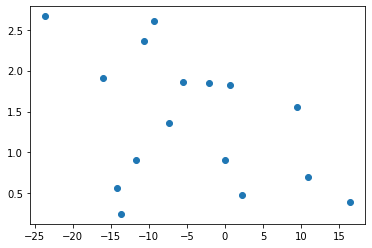

In [12]:
plt.plot(mu_p0, sigma_p0, 'o')

### Now run the MCMC to create a random sample

In [13]:
sampler.run_mcmc(p0, 1000);

### Now you can start inspecting and interrogating the random sample.

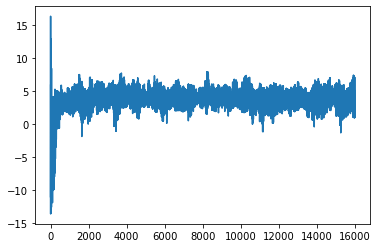

In [14]:
plt.plot(sampler.flatchain[:,0])

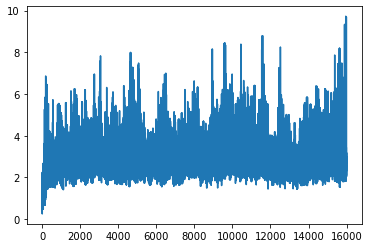

In [15]:
plt.plot(sampler.flatchain[:,1])

Text(0.5, 0, '$\\mu$')

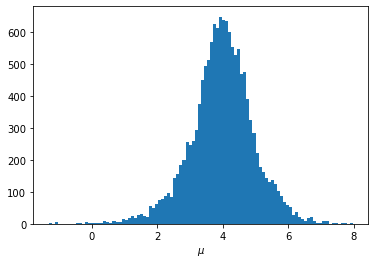

In [16]:
plt.hist(sampler.flatchain[2000:, 0], bins=100);
plt.xlabel('$\mu$')

Text(0.5, 0, '$\\sigma$')

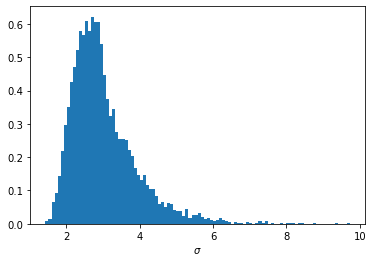

In [17]:
plt.hist(sampler.flatchain[2000:, 1], bins=100, density=True);
plt.xlabel('$\sigma$')

Text(0.5, 0, '$\\mu$')

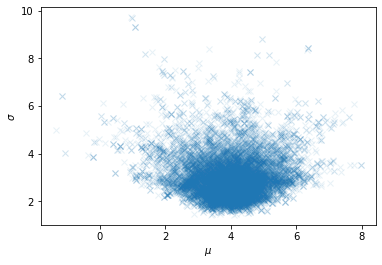

In [18]:
plt.plot(sampler.flatchain[2000:, 0], sampler.flatchain[2000:, 1], 'x', alpha=0.1)
plt.ylabel('$\sigma$')
plt.xlabel('$\mu$')

In [19]:
import corner

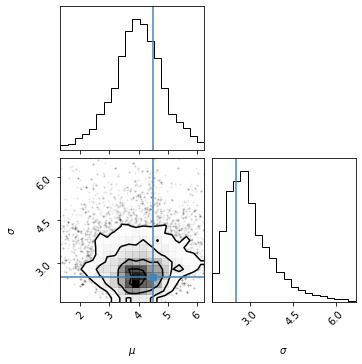

In [20]:
fig = corner.corner(sampler.flatchain[2000:], labels=['$\mu$', '$\sigma$'], truths=[4.5, 2.5], range=(0.98, 0.99))